# **Ayudantía Redes Neuronales**

## Tabla de Contenidos
* [Importando Librerías y Cargando Datos](#ch1)
* [Creando una Red Neuronal](#ch2)
* [Optimizaciones/Modificaciones](#ch3)
    * [Early Stopping](#ch31)
    * [Dropout](#ch32)
    * [Pruning](#ch33)
* [Creando una Red Neuronal Sin Utilizar Keras](#ch4)

## Importando Librerías y Cargando Datos <a class="anchor" id="ch1"></a>

In [1]:
# Importamos librerías de utilidad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Importamos tensorflow
import tensorflow as tf

In [3]:
# Tensorflow viene con un dataset de MNIST. Cargamos el dataset
fashion_mnist = tf.keras.datasets.fashion_mnist

# Ahora lo cargamos en 4 arrays
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Veamos las dimensiones del dataset
print(f"\nLa base de datos de entrenamiento tiene {train_images.shape[0]} imágenes de {train_images.shape[1]} x {train_images.shape[2]}")
print(f"\nLa base de datos de testeo tiene {test_images.shape[0]} imágenes de {test_images.shape[1]} x {test_images.shape[2]}")


La base de datos de entrenamiento tiene 60000 imágenes de 28 x 28

La base de datos de testeo tiene 10000 imágenes de 28 x 28


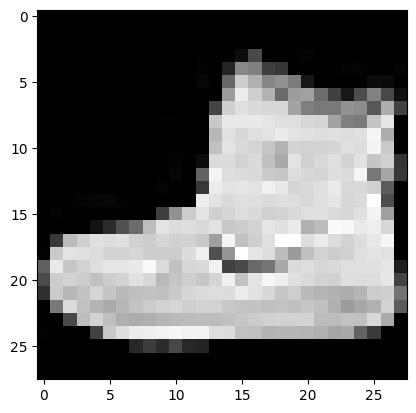

In [4]:
# A modo de ejemplo, veamos la primera imagen del dataset (es una bota)
plt.imshow(train_images[0], cmap='gray')

In [5]:
# Por convenienca, normalizamos las imágenes. Esto ayuda a que los pesos de la red no tomen valores muy grandes (es decir, en un rango muy amplio)
train_images = train_images / 255.0
test_images = test_images / 255.0

In [6]:
# Si quisieramos, podemos tomar una porción de los datos de entrenamiento para usarlos como validación
# Esto nos permite ver cómo se comporta la red en datos que no fueron usados para entrenarla

# Tomamos las primeras 5.000 imágenes
X_valid = train_images[:5000]

# Ahora debemos dejar la base de entrenamiento sin esas 5.000 imágenes
X_train = train_images[5000:]

# Hacemos lo mismo para la variable respuesta
y_valid = train_labels[:5000]
y_train = train_labels[5000:]

In [7]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Como las imágenes son de 28x28, las podemos aplanar y usarlas directamente como vectores input de la red
train_images = train_images.reshape(np.shape(train_images)[0], 784)
test_images = test_images.reshape(np.shape(test_images)[0], 784)

# Veamos las nuevas dimensiones
print(np.shape(train_images))

(60000, 784)


## Creando una Red Neuronal <a class="anchor" id="ch2"></a>

In [23]:
# Hay muchas maneras de construir una red neuronal. Por ahora, vamos a usar la clase Sequential de Keras

model = tf.keras.Sequential([
# En caso de no aplanar las imágenes previamente, podemos usar la siguiente línea
tf.keras.layers.Flatten(input_shape=(28, 28)),
# Ahora agregamos las capas ocultas
tf.keras.layers.Dense(50, activation='relu'),
tf.keras.layers.Dense(100, activation='relu'),
tf.keras.layers.Dense(500, activation='relu'),
tf.keras.layers.Dense(10)
])


# También podemos definir una función auxiliar para compilar una red
def compile_model(n_layers, n_neurons, activation, optimizer, metrics):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    for i in range(n_layers):
        model.add(tf.keras.layers.Dense(n_neurons[i], activation=activation))
    model.add(tf.keras.layers.Dense(10))
    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=metrics)
    return model

In [16]:
# Ahora, para compilar el modelo debemos especificar el optimizador, la función de pérdida y las métricas que queremos usar para entrenar la red
model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

In [17]:
# Por ahora, utilizaremos batches para entrenar más rápido la red
# Definimos el tamaño de cada batch
batch_size = 256
# Definimos la cantidad de épocas de entrenamiento
epochs = 30

# Guardamos el historial del entrenamiento
history = model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = epochs, batch_size = batch_size)

Epoch 1/30
215/215 [==============================] - 1s 4ms/step - loss: 0.6375 - accuracy: 0.7751 - val_loss: 0.4729 - val_accuracy: 0.8328
Epoch 2/30
215/215 [==============================] - 1s 3ms/step - loss: 0.4142 - accuracy: 0.8509 - val_loss: 0.3814 - val_accuracy: 0.8644
Epoch 3/30
215/215 [==============================] - 1s 3ms/step - loss: 0.3771 - accuracy: 0.8637 - val_loss: 0.3688 - val_accuracy: 0.8644
Epoch 4/30
215/215 [==============================] - 1s 2ms/step - loss: 0.3468 - accuracy: 0.8736 - val_loss: 0.3606 - val_accuracy: 0.8684
Epoch 5/30
215/215 [==============================] - 1s 2ms/step - loss: 0.3310 - accuracy: 0.8791 - val_loss: 0.3372 - val_accuracy: 0.8768
Epoch 6/30
215/215 [==============================] - 1s 3ms/step - loss: 0.3125 - accuracy: 0.8852 - val_loss: 0.3233 - val_accuracy: 0.8832
Epoch 7/30
215/215 [==============================] - 1s 2ms/step - loss: 0.3004 - accuracy: 0.8885 - val_loss: 0.3280 - val_accuracy: 0.8840
Epoch 

In [18]:
# Creamos una función de ayuda para extraer la información guardada en el objeto history
def plot_history(history):

    # Hacemos una grilla de 2 figuras
    fig, axs = plt.subplots(2, figsize = (10, 10))

    # Graficamos los accuracy tanto el set de entrenamiento como el de validación
    axs[0].plot(history.history["accuracy"], label = "Accuracy entrenamiento")
    axs[0].plot(history.history["val_accuracy"], label = "Accuracy validación")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc = "lower right")
    axs[0].set_title("Accuracy por épocas")

    # De la misma manera, graficamos el error tanto para el set de entrenamiento como el de validación
    axs[1].plot(history.history["loss"], label="Error entrenamiento")
    axs[1].plot(history.history["val_loss"], label="Error validación")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Época")
    axs[1].legend(loc = "upper right")
    axs[1].set_title("Error por épocas")

    # Mostramos la figura 
    plt.show()

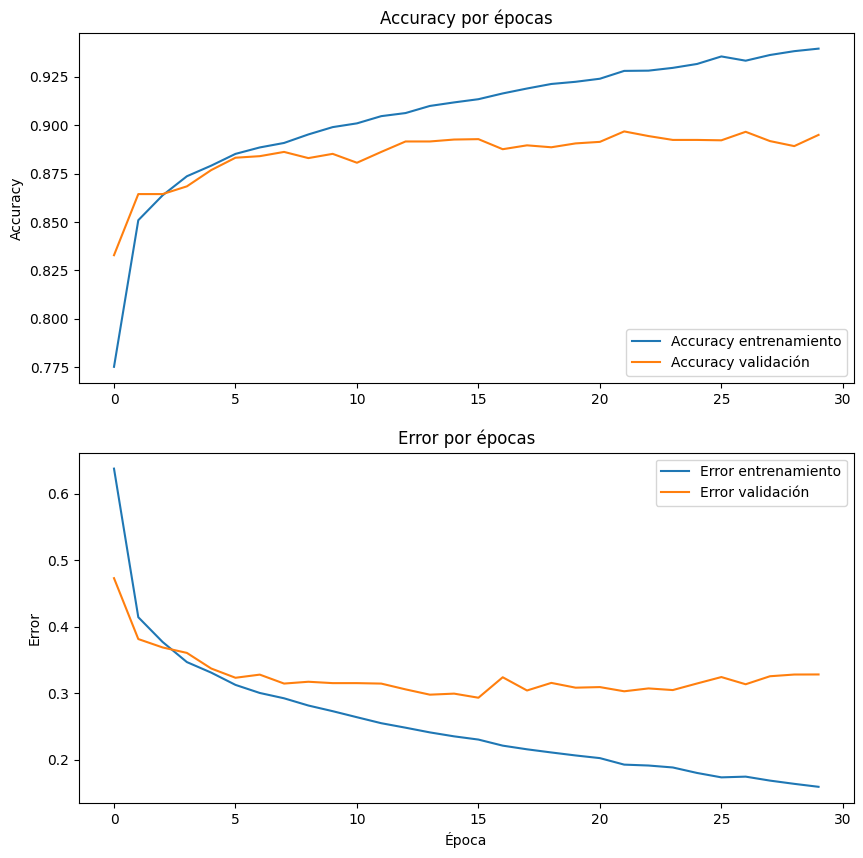

In [19]:
plot_history(history)

Intentemos mejorar el accuracy agregando más capas ocultas con más neuronas

In [24]:
model = compile_model(4, (100,200,200,100), "relu", "adam", ["accuracy"])

# Definimos el tamaño de cada batch
batch_size = 256

# Definimos la cantidad de épocas de entrenamiento
epochs = 30

# Ajustamos el modelo
history = model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = epochs, batch_size = batch_size)

Epoch 1/30
215/215 [==============================] - 1s 4ms/step - loss: 0.6183 - accuracy: 0.7831 - val_loss: 0.4093 - val_accuracy: 0.8570
Epoch 2/30
215/215 [==============================] - 1s 3ms/step - loss: 0.3993 - accuracy: 0.8559 - val_loss: 0.3587 - val_accuracy: 0.8720
Epoch 3/30
215/215 [==============================] - 1s 3ms/step - loss: 0.3552 - accuracy: 0.8701 - val_loss: 0.3451 - val_accuracy: 0.8756
Epoch 4/30
215/215 [==============================] - 1s 3ms/step - loss: 0.3298 - accuracy: 0.8784 - val_loss: 0.3366 - val_accuracy: 0.8792
Epoch 5/30
215/215 [==============================] - 1s 3ms/step - loss: 0.3066 - accuracy: 0.8866 - val_loss: 0.3249 - val_accuracy: 0.8824
Epoch 6/30
215/215 [==============================] - 1s 3ms/step - loss: 0.2918 - accuracy: 0.8921 - val_loss: 0.3206 - val_accuracy: 0.8852
Epoch 7/30
215/215 [==============================] - 1s 3ms/step - loss: 0.2788 - accuracy: 0.8970 - val_loss: 0.2899 - val_accuracy: 0.8928
Epoch 

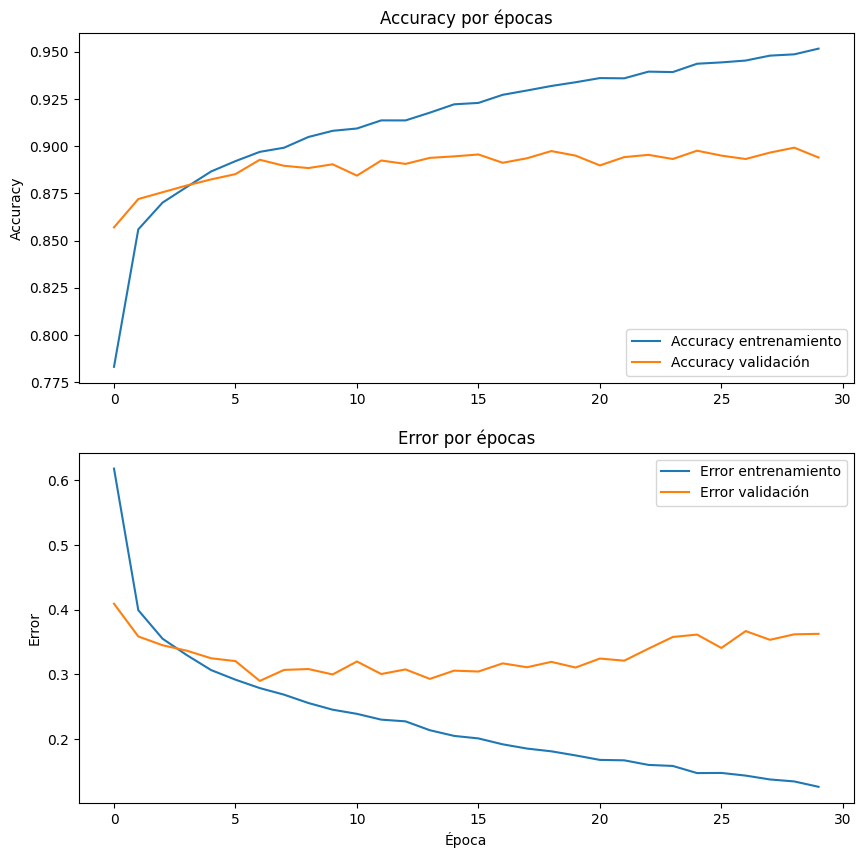

In [25]:
plot_history(history)

Vemos que estamos alcanzando un mejor accuracy al agregar más neuronas. 

Sin embargo, ¿serán todos los parámetros necesarios? Es decir, ¿podemos encapsular la misma información aprendida pero con menos parámetros? Como vimos, al tener menos neuronas pareciera que el accuracy no es tan bueno. Una posible solución es realizar algún tipo de poda. Esto lo veremos un poco después (más abajo).

# Optimizaciones/Modificaciones <a class="anchor" id="ch3"></a>

¿Qué pasa si entrenamos sin batches? ¿Tomará mucho tiempo?

In [54]:
model = compile_model(4, (100,200,200,100), "relu", "adam", ["accuracy"])

model.fit(
    X_train,
    y_train,
    validation_data = (X_valid, y_valid),
    epochs=30
)

Epoch 1/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5030 - accuracy: 0.8173 - val_loss: 0.4035 - val_accuracy: 0.8510
Epoch 2/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3745 - accuracy: 0.8627 - val_loss: 0.3712 - val_accuracy: 0.8682
Epoch 3/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3397 - accuracy: 0.8746 - val_loss: 0.3203 - val_accuracy: 0.8830
Epoch 4/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3183 - accuracy: 0.8825 - val_loss: 0.3306 - val_accuracy: 0.8840
Epoch 5/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2981 - accuracy: 0.8893 - val_loss: 0.3072 - val_accuracy: 0.8910
Epoch 6/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2854 - accuracy: 0.8939 - val_loss: 0.3114 - val_accuracy: 0.8906
Epoch 7/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2722 - accuracy: 0.8983 - val_loss: 0.3309 - val_accuracy:

Efectivamente toma mucho tiempo (en comparación a entrenar con batches). Además, vemos que los accuracies se empiezan a estancar (tal como lo vimos en los gráficos anteriores).

Una solución es parar el entrenamiento luego de una cierta cantidad de épocas en donde el modelo no está mejorando significativamente.

## Early Stopping <a class="anchor" id="ch31"></a>

In [56]:
# Importamos el callback que usaremos
from tensorflow.keras.callbacks import EarlyStopping

# Definimos el EarlyStopping
early_stopping = EarlyStopping(patience = 3, monitor = "val_accuracy", restore_best_weights = True)

# Volvemos a compilar el primer modelo
model = compile_model(4, (100,200,200,100), "relu", "adam", ["accuracy"])

# Definimos el tamaño de cada batch si es que lo quieren usar (recomendado)
#batch_size = 256

# Definimos la cantidad de épocas de entrenamiento
epochs = 30

# Agregamos callbacks = [early_stopping] al método fit para que detecte cuando se estanca el entrenamiento
history = model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = epochs, callbacks = [early_stopping])

Epoch 1/30
1719/1719 [==============================] - 3s 1ms/step - loss: 0.5049 - accuracy: 0.8166 - val_loss: 0.3877 - val_accuracy: 0.8534
Epoch 2/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3753 - accuracy: 0.8617 - val_loss: 0.3594 - val_accuracy: 0.8612
Epoch 3/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3435 - accuracy: 0.8732 - val_loss: 0.3140 - val_accuracy: 0.8858
Epoch 4/30
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3175 - accuracy: 0.8832 - val_loss: 0.3203 - val_accuracy: 0.8836
Epoch 5/30
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2989 - accuracy: 0.8896 - val_loss: 0.3182 - val_accuracy: 0.8858
Epoch 6/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2860 - accuracy: 0.8925 - val_loss: 0.3259 - val_accuracy: 0.8784


Vemos que paró el entrenamiento apenas en la sexta época. Esto definitivamente ahorra tiempo, pero observemos el gráfico

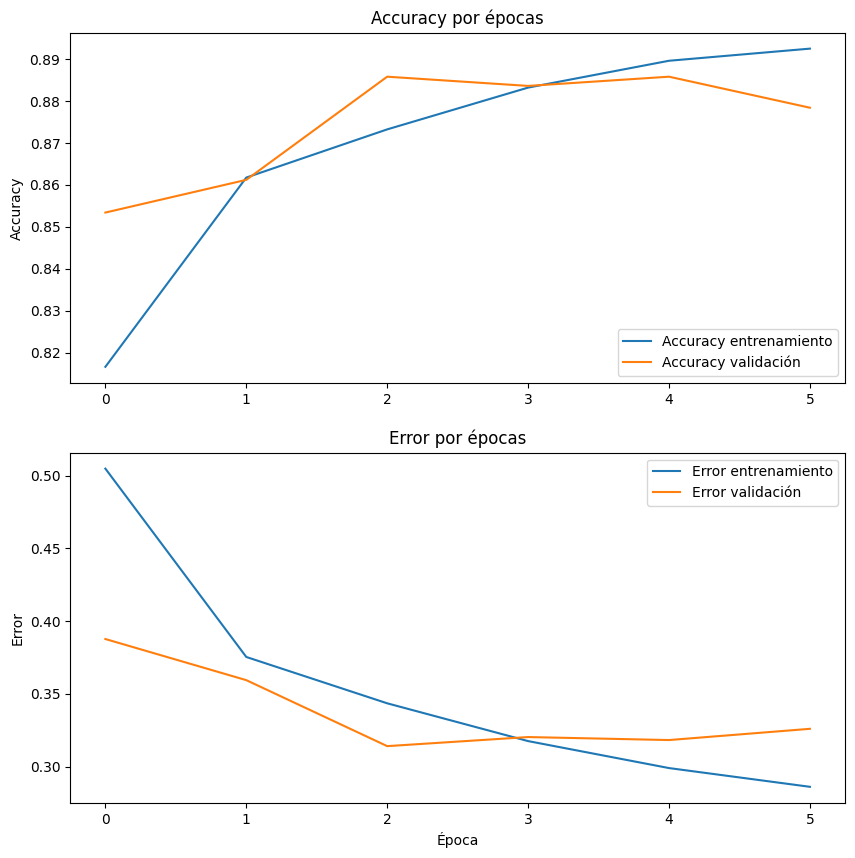

In [57]:
plot_history(history)

Ahora, ¿qué podemos hacer si nos importa mucho que nuestra red sea robusta ante datos nuevos y que no ocurra overfitting? Una posible solución es podar neuronas y/o parámetros. Veamos esto durante el entrenamiento (Dropout) y después del entrenamiento (Pruning).

## Dropout <a class="anchor" id="ch32"></a>

Dropout permite quitar un cierto porcentaje de NEURONAS aleatoriamente con cierta probabilidad en cada iteración.

<img src="https://miro.medium.com/max/1044/1*iWQzxhVlvadk6VAJjsgXgg.png">

In [64]:
model = tf.keras.Sequential([
tf.keras.layers.Flatten(input_shape=(28, 28)),
tf.keras.layers.Dense(100, activation='relu'),
# Esta es una capa de Dropout
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(200, activation='relu'),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(200, activation='relu'),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(100, activation='relu'),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(10)
])

model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

batch_size = 256
epochs = 30
history = model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = epochs, batch_size=batch_size)

Epoch 1/30
215/215 [==============================] - 1s 4ms/step - loss: 1.0395 - accuracy: 0.6152 - val_loss: 0.5193 - val_accuracy: 0.8126
Epoch 2/30
215/215 [==============================] - 1s 4ms/step - loss: 0.6069 - accuracy: 0.7852 - val_loss: 0.4249 - val_accuracy: 0.8462
Epoch 3/30
215/215 [==============================] - 1s 4ms/step - loss: 0.5467 - accuracy: 0.8090 - val_loss: 0.4200 - val_accuracy: 0.8506
Epoch 4/30
215/215 [==============================] - 1s 4ms/step - loss: 0.5095 - accuracy: 0.8251 - val_loss: 0.3857 - val_accuracy: 0.8670
Epoch 5/30
215/215 [==============================] - 1s 4ms/step - loss: 0.4845 - accuracy: 0.8314 - val_loss: 0.3711 - val_accuracy: 0.8630
Epoch 6/30
215/215 [==============================] - 1s 4ms/step - loss: 0.4686 - accuracy: 0.8364 - val_loss: 0.3731 - val_accuracy: 0.8678
Epoch 7/30
215/215 [==============================] - 1s 4ms/step - loss: 0.4575 - accuracy: 0.8395 - val_loss: 0.3542 - val_accuracy: 0.8702
Epoch 

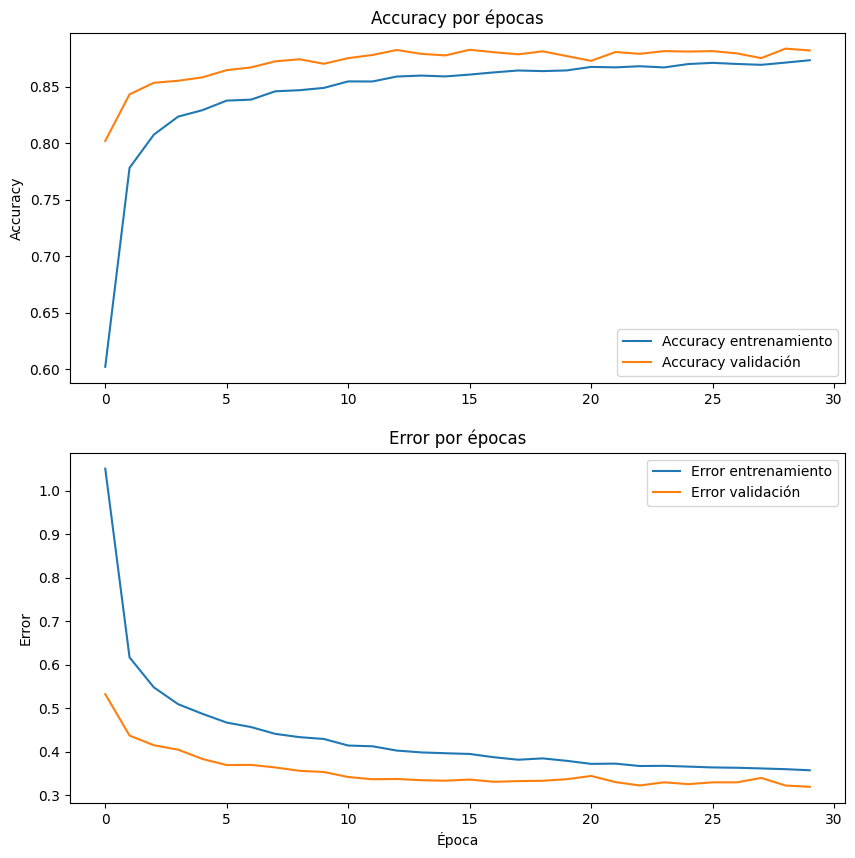

In [60]:
plot_history(history)

# Pruning <a class="anchor" id="ch33"></a>

La idea detrás de esto es entrenar un modelo con todas las neuronas que queramos, pero luego guardamos solo los parámetros que codifican información. Por ejemplo, y como lo haremos a continuación, aquellos que estén sobre algún valor threshold. En otras palabras, los parámetros que tomen valores muy pequeños los truncamos a 0 simplemente.

La gracia de esto es que almacenar matrices sparse (recordemos que este tipo de redes neuronales se pueden representar como matrices) es más eficiente (solo almacenamos las entradas distintas a cero), entre muchos otros beneficios. 

In [26]:
# Importamos la librería que nos ayuda a hacer pruning. Es una librería que no viene incluida en tensorflow mismo y hay que instalarla
import tensorflow_model_optimization as tfmot

# Definimos la función que aplica el pruning a una capa densa
def apply_pruning_to_dense_40(layer):
  pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(
          target_sparsity=0.4,#qué porcentaje de pesos queremos podar
          begin_step=1, #en qué paso empezar a podar
          end_step=-1, #en qué paso terminar de podar (-1 es al final)
          frequency=5 #cada "frequency" pasos deberíamos podar (no son epochs)
      )
}
  if isinstance(layer, tf.keras.layers.Dense):
    return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)# "prune_low_magnitude" es el método que aplica el pruning
  return layer

In [61]:
base_model = compile_model(4, (100,200,200,100), "relu", "adam", ["accuracy"])
history = base_model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 30, batch_size = 256)

Epoch 1/30
215/215 [==============================] - 1s 3ms/step - loss: 0.6375 - accuracy: 0.7731 - val_loss: 0.4237 - val_accuracy: 0.8538
Epoch 2/30
215/215 [==============================] - 1s 3ms/step - loss: 0.4084 - accuracy: 0.8512 - val_loss: 0.3721 - val_accuracy: 0.8668
Epoch 3/30
215/215 [==============================] - 1s 3ms/step - loss: 0.3566 - accuracy: 0.8687 - val_loss: 0.3505 - val_accuracy: 0.8688
Epoch 4/30
215/215 [==============================] - 1s 3ms/step - loss: 0.3281 - accuracy: 0.8794 - val_loss: 0.3286 - val_accuracy: 0.8778
Epoch 5/30
215/215 [==============================] - 1s 3ms/step - loss: 0.3106 - accuracy: 0.8860 - val_loss: 0.3266 - val_accuracy: 0.8804
Epoch 6/30
215/215 [==============================] - 1s 3ms/step - loss: 0.2945 - accuracy: 0.8913 - val_loss: 0.3189 - val_accuracy: 0.8836
Epoch 7/30
215/215 [==============================] - 1s 3ms/step - loss: 0.2805 - accuracy: 0.8952 - val_loss: 0.3042 - val_accuracy: 0.8898
Epoch 

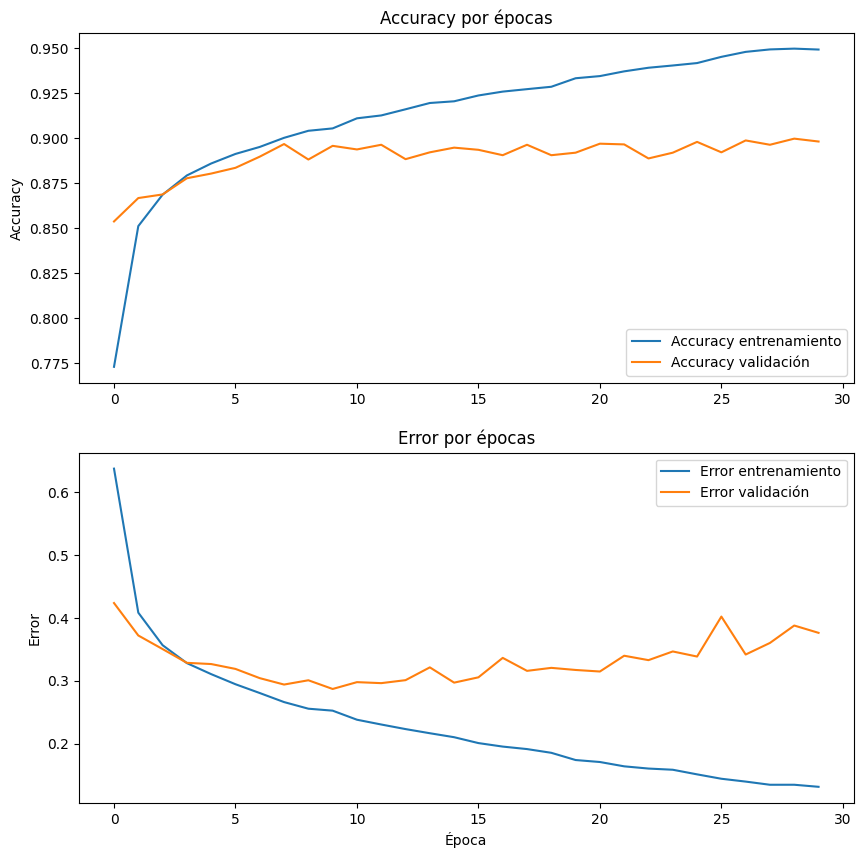

In [62]:
plot_history(history)

In [29]:
model = compile_model(4, (100,200,200,100), "relu", "adam", ["accuracy"])

loss, acc = model.evaluate(X_train, y_train, verbose=2)

# Clonamos el modelo pero utilizamos la función de pruning en el proceso
model_for_pruning = tf.keras.models.clone_model(
    base_model,
    clone_function=apply_pruning_to_dense_40,
)

model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Aquí también usamos callbacks, pero en este caso es para actualizar los pesos
callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]

# Entrenamos el modelo igual que antes
pruning_history = model_for_pruning.fit(
    X_train,
    y_train,
    validation_data = (X_valid, y_valid),
    callbacks = callbacks,
    epochs=30
)



1719/1719 - 1s - loss: 2.3225 - accuracy: 0.0814 - 949ms/epoch - 552us/step
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Epoch 1/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5191 - accuracy: 0.8125 - val_loss: 0.3983 - val_accuracy: 0.8596
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3753 - accuracy: 0.8605 - val_loss: 0.3620 - val_accuracy: 0.8658
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3360 - accuracy: 0.8756 - val_loss: 0.3334 - val_accuracy: 0.8794
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3104 - accuracy: 0.8850 - val_loss: 0.3237 - val_accuracy: 0.8832
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2901 - accuracy: 0.8913 - val_loss: 0.3276 - val_accuracy: 0.8788
Epo

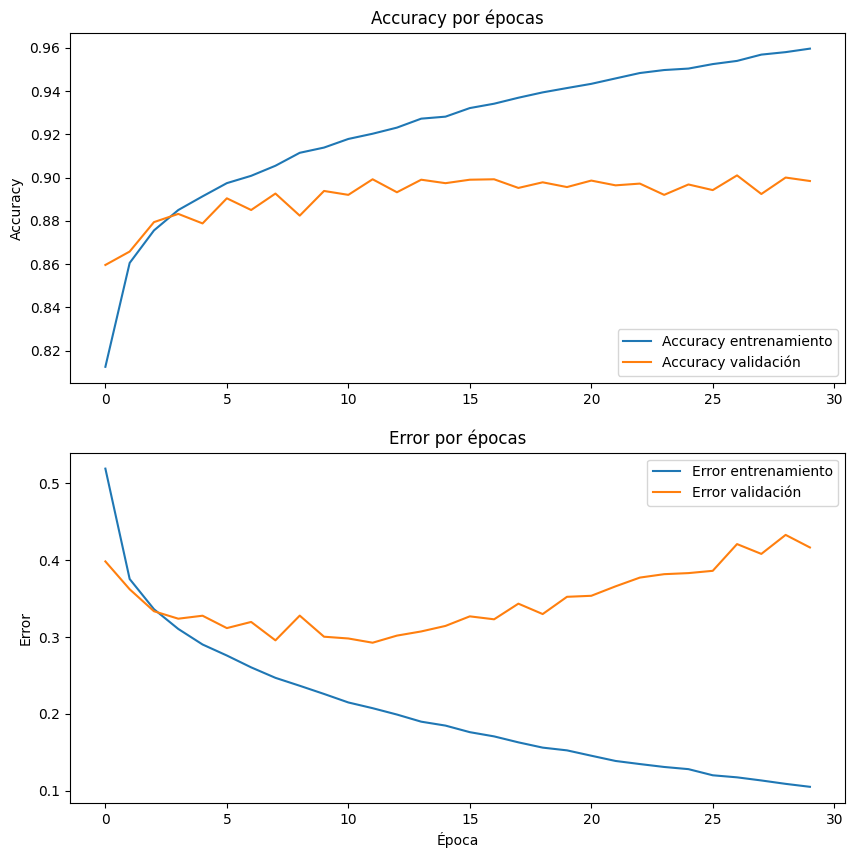

In [30]:
plot_history(pruning_history)

In [46]:
# Definimos una función para extraer los pesos de la red
def get_params(model, n_layers):
    w = []
    b = []
    # En este caso, nos saltamos la priemra capa porque es la de aplanamiento
    for i in range(1,n_layers+1):
        w.append(model.layers[i].get_weights()[0].T)
        b.append(model.layers[i].get_weights()[1].T)

    return w, b

In [63]:
# Revisemos que el pruning efectivamente funcionó

# Primero, consigamos los parámetros de la red sin pruning
w_np, b_np = get_params(base_model, 4)
# Contemos la cantidad de parámetros no nulos
for i in range(1,5):
    w_i = w_np[i-1]
    sparsity = 1 - np.count_nonzero(w_i)/float(w_i.size)
    print(f"Sparsity of layer {i} for original model: {sparsity}")

# Repitamos el proceso para la red con pruning
w_p, b_p = get_params(model_for_pruning, 4)
for i in range(1,5):
    w_i = w_p[i-1]
    sparsity = 1 - np.count_nonzero(w_i)/float(w_i.size)
    print(f"Sparsity of layer {i} for pruned model: {sparsity}")

Sparsity of layer 1 for original model: 0.0
Sparsity of layer 2 for original model: 0.0
Sparsity of layer 3 for original model: 0.0
Sparsity of layer 4 for original model: 0.0
Sparsity of layer 1 for pruned model: 0.4
Sparsity of layer 2 for pruned model: 0.4
Sparsity of layer 3 for pruned model: 0.4
Sparsity of layer 4 for pruned model: 0.4


Es decir, tenemos que un 40% de los pesos de la red son 0, y alcanzamos un accuracy similar a la red sin pruning!

Si les interesa más del tema, les dejo un paper sobre este tema. La idea es que uno puede obtener, a partir de una red entrenada, una subred (con muy pocos parámetros) que obtiene rendimientos muy parecidos, o incluso mejores, a la red neuronal original. No es trivial cuándo esto ocurre, por lo que hay muchas investigaciones sobre el tema.

The Lottery Ticket Hypothesis: Finding Sparse, Trainable Neural Networks (el paper original): https://arxiv.org/abs/1803.03635

## Creando una Red Neuronal Sin Utilizar Keras <a class="anchor" id="ch4"></a>

Si bien Keras es muy útil, podemos crear una red neuronal desde cero (casi) nosotros mismos. Los conceptos son los mismos que los vistos en clases.

In [78]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.L = len(layers)
        self.num_features = layers[0]
        self.num_classes = layers[-1]
        # Guaramos nuetros weights y biases en diccionarios
        self.W = {}
        self.b = {}
        # Estos los utilizaremos para los gradientes
        self.dW = {}
        self.db = {}
        
        self.setup()
        
    def setup(self):
       # Inicializamos los parámetros de la red, utilizando una distribución normal para los parámetros
       # Esta inizialización importa bastante a la hora de construir una red. Otra alternativa es usar una distribución uniforme
        for i in range(1, self.L):
            self.W[i] = tf.Variable(tf.random.normal(shape=(self.layers[i],self.layers[i-1])))
            self.b[i] = tf.Variable(tf.random.normal(shape=(self.layers[i],1)))
    
    def forward_pass(self, X):
        # Esto es tal cual como se vio en clases
        A = tf.convert_to_tensor(X, dtype=tf.float64)
        for i in range(1, self.L):
            # Esto es tranformar el input de la capa en su output
            Z = tf.matmul(A,tf.transpose(self.W[i])) + tf.transpose(self.b[i])
            if i != self.L-1:
                # Aquí aplicamos la función de activación
                # Se puede cambiar por otra función de activación
                A = tf.nn.relu(Z)
            else:
                A = Z
        return A
    
    def compute_loss(self, A, Y):
        loss = tf.nn.softmax_cross_entropy_with_logits(Y,A)
        return tf.reduce_mean(loss)
    
    
    def update_params(self, lr):
        for i in range(1,self.L):
            self.W[i].assign_sub(lr * self.dW[i])
            self.b[i].assign_sub(lr * self.db[i])
    
    def predict(self, X):
        # Realizamos el forward pass para transformar el input en un output
        A = self.forward_pass(X)
        # Aplicamos la función de activación softmax para obtener las probabilidades y luego tomamos el mayor
        return tf.argmax(tf.nn.softmax(A), axis=1)
    
    def train_on_batch(self, X, Y, lr):
        X = tf.convert_to_tensor(X, dtype=tf.float64)
        Y = tf.convert_to_tensor(Y, dtype=tf.float64)
        # El GradientTape nos permite calcular los gradientes de los parámetros e ir guardando un historial de lo que hacemos
        with tf.GradientTape(persistent=True) as tape:
            A = self.forward_pass(X)
            loss = self.compute_loss(A, Y)
        for i in range(1, self.L):
            # Se utiliza diferenciación automática para calcular los gradientes
            self.dW[i] = tape.gradient(loss, self.W[i])
            self.db[i] = tape.gradient(loss, self.b[i])
        del tape
        self.update_params(lr)
        return loss.numpy()

    def train(self, x_train, y_train, x_test, y_test, epochs, steps_per_epoch, batch_size, lr):
        history = {
            'val_loss':[],
            'train_loss':[],
            'val_acc':[]
        }
        for e in range(0, epochs):
            epoch_train_loss = 0.
            print('Epoch {}'.format(e), end='.')
            for i in range(0, steps_per_epoch):
                x_batch = x_train[i*batch_size:(i+1)*batch_size]
                y_batch = y_train[i*batch_size:(i+1)*batch_size]
                
                batch_loss = self.train_on_batch(x_batch, y_batch,lr)
                epoch_train_loss += batch_loss
                
                if i%int(steps_per_epoch/10) == 0:
                    print(end='.')
                    
            history['train_loss'].append(epoch_train_loss/steps_per_epoch)
            val_A = self.forward_pass(x_test)
            val_loss = self.compute_loss(val_A, y_test).numpy()
            history['val_loss'].append(val_loss)
            val_preds = self.predict(x_test)
            val_acc =    np.mean(np.argmax(y_test, axis=1) == val_preds.numpy())
            history['val_acc'].append(val_acc)
            print('Validation accuracy:',val_acc)
        return history

In [74]:
from keras.utils import to_categorical

model = NeuralNetwork([784,128,128,10])

y_train_net = to_categorical(y_train)
y_valid_net = to_categorical(y_valid)

x_train_net = X_train.reshape(np.shape(X_train)[0], 784)
x_valid_net = X_valid.reshape(np.shape(X_valid)[0], 784)

batch_size = 120
epochs = 5
steps_per_epoch = int(train_images.shape[0]/batch_size)
lr = 3e-3

history = model.train(
    x_train_net,y_train_net,
    x_valid_net, y_valid_net,
    epochs, steps_per_epoch,
    batch_size, lr)

Epoch0...........Val acc: 0.6936
Epoch1...........Val acc: 0.7256
Epoch2...........Val acc: 0.7478
Epoch3...........Val acc: 0.7336
Epoch4...........Val acc: 0.7278


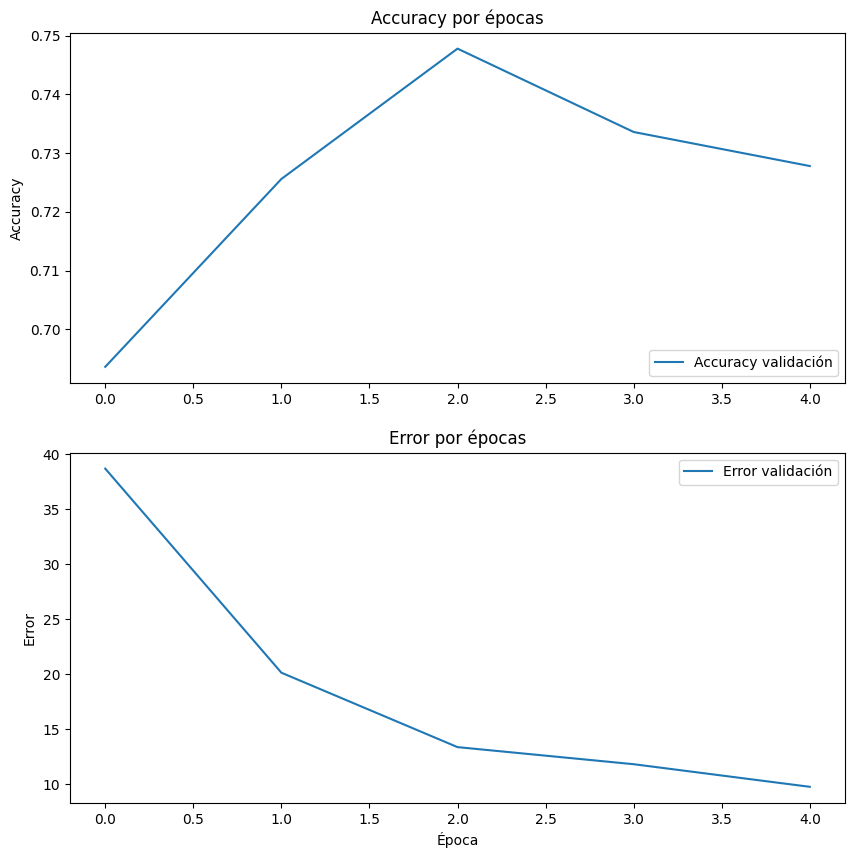

In [77]:
def plot_history(history):
    fig, axs = plt.subplots(2, figsize = (10, 10))
    axs[0].plot(history["val_acc"], label = "Accuracy validación")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc = "lower right")
    axs[0].set_title("Accuracy por épocas")
    axs[1].plot(history["val_loss"], label="Error validación")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Época")
    axs[1].legend(loc = "upper right")
    axs[1].set_title("Error por épocas")
    plt.show()

plot_history(history)

Pueden leer más en: https://ruslanmv.com/blog/Neural-Networks-in-Tensorflow